# Precipitation measurements

Example of homemade rain gauge precipitation measurements with the help of kids toy-buckets and some bayesian mathematics.

See https://en.wikipedia.org/wiki/Rain_gauge

Measurements were done overnight between 24.-25.7.2020.

## Weather station measurements
Espoo, Nuuksio, <15 km from the measurement location  
Espoo, Tapiola, <15 km from the measurement location  
https://www.ilmatieteenlaitos.fi/havaintojen-lataus

## Problem definition

The aim is to estimate precipitation based on simple measurement setup.
Two buckets (blue and yellow) were left outside overnight to gather rain precipitation.
The diameter of the bucket was measured a few times with a tape measure.
At the morning next day, the buckets were weighted with and without the precipitated water.
Scale was tared between the measurements and the buckets were placed approximately center.

Scale used for the weighting has approximately absolute accuracy of +/- 2 grams and the result is rounded to the closest 1 gram.
Tape measure results were inferred from the photograph and are given +/- 2 centimeter accuracy.

In [1]:
import pystan
import numpy as np
import pandas as pd
import arviz as az

## FMI Measurement data

In [2]:
fmi_data = pd.concat([pd.read_csv(path) for path in ("../FMI_DATA/fmi_espoo_nuuksio_2020-07-24.csv", "../FMI_DATA/fmi_espoo_nuuksio_2020-07-25.csv")], axis=0)

In [3]:
fmi_data = fmi_data.rename(columns={"Vuosi" : "year", "Kk" : "month", "Pv" : "day", "Klo" : "time"})

In [4]:
fmi_data[["hour", "minutes"]] = fmi_data["time"].apply(lambda x: pd.Series(x.split(":"), index=["hour", "minutes"]))

In [5]:
fmi_data = fmi_data.set_index(pd.to_datetime(fmi_data[["year", "month", "day", "hour", "minutes"]]))

In [6]:
slicer = (fmi_data.index < pd.datetime.strptime("2020-07-25 13:00", "%Y-%m-%d %H:%M")) & (fmi_data.index > pd.datetime.strptime("2020-07-24 22:00", "%Y-%m-%d %H:%M"))

In [7]:
fmi_result = (fmi_data[slicer]["Sateen intensiteetti (mm/h)"] / 6).sum()
print(f"{fmi_result:.2f} mm") # 10 km

1.35 mm


# Data

Similar measurements are i.i.d which means that different measurements should not be paired.
Number of measurements between the differents objecs (blue, yellow or water, no-water) can differ,
but are the same in this example.

## Weights (in grams)

In [8]:
weight_bucket = pd.DataFrame.from_dict({
    "blue" : np.array([127, 128, 128]),
    "yellow" : np.array([129, 129, 128]),
})
weight_bucket_water = pd.DataFrame.from_dict({
    "blue" : np.array([170, 169, 169]),
    "yellow" : np.array([168, 169, 168]),
})

In [9]:
weight_bucket

,blue,yellow
0,127,129
1,128,129
2,128,128


In [10]:
weight_bucket_water

,blue,yellow
0,170,168
1,169,169
2,169,168


# Lengths (in centimeters)

In [11]:
import matplotlib.pyplot as plt

## Geometry

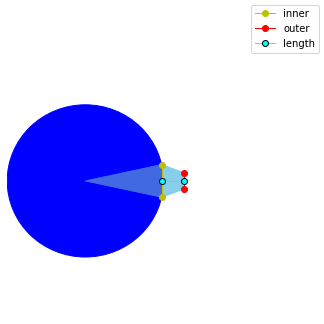

In [12]:
fig, ax = plt.subplots(figsize=(5,5))

# base circle
ax.add_artist(plt.Circle((-11,0), radius=14, color="blue", alpha=1))

# wedge
dx = (14**2 - 3**2)**0.5
dy = 3
dx_2 = dx + 4.0
dy_2 = 1.5
ax.add_artist(plt.Polygon([
    (dx-11, dy),
    (dx_2-11, dy_2),
    (dx_2-11, -dy_2),
    (dx-11, -dy),
    
], alpha=1, color="skyblue"))

ax.add_artist(plt.Polygon([
    (0-11, 0),
    (dx-11, dy),
    (dx-11, -dy),  
], alpha=1, color="royalblue"))

ax.plot([dx-11, dx-11], [dy, -dy], color="y", lw=1, marker='o', label="inner")
ax.plot([dx_2-11, dx_2-11], [dy_2, -dy_2], color="red", lw=1, marker='o', label="outer")
ax.plot([dx-11, dx_2-11], [0, 0], color="cyan", lw=1, marker='o', markeredgecolor="k", label="length")



ax.set_xlim(-25,25)
ax.set_ylim(-25,25)
ax.axis("off")
fig.legend()

In [13]:
diameter_bucket = pd.DataFrame.from_dict({
    "blue" : np.array([14.8-1.0]),
    "yellow" : np.array([15.0-1.0]),
})

radius_bucket = diameter_bucket / 2

# 
wedge_bucket_inner = pd.DataFrame.from_dict({
    "blue" : np.array([6.0]),
    "yellow" : np.array([6.0])
})

wedge_bucket_outer = pd.DataFrame.from_dict({
    "blue" : np.array([3.0]),
    "yellow" : np.array([3.0])
})


wedge_bucket_lenght = pd.DataFrame.from_dict({
    "blue" : np.array([4.0]),
    "yellow" : np.array([4.0])
})

In [14]:
circumference_bucket = 2 * np.pi * radius_bucket

In [15]:
circumference_bucket

,blue,yellow
0,43.353979,43.982297


In [16]:
# radians
wedge_angle = 2 * np.pi * wedge_bucket_inner / circumference_bucket
wedge_angle

,blue,yellow
0,0.869565,0.857143


In [17]:
wedge_area_outside = wedge_bucket_outer * wedge_bucket_lenght + abs(wedge_bucket_inner - wedge_bucket_outer) * wedge_bucket_lenght
wedge_triangle_p = (radius_bucket * 2 + wedge_bucket_inner) / 2
wedge_area_inside = np.sqrt(wedge_triangle_p * (wedge_triangle_p - radius_bucket)**2 * (wedge_triangle_p - wedge_bucket_inner))

In [18]:
wedge_area_outside

,blue,yellow
0,24.0,24.0


In [19]:
wedge_area_inside

,blue,yellow
0,18.641084,18.973666


In [20]:
bucket_area_inside = np.pi * radius_bucket**2 - 0.5 * radius_bucket**2 * (wedge_angle - np.sin(wedge_angle)) + np.sqrt(wedge_triangle_p * (wedge_triangle_p - radius_bucket)**2 * (wedge_triangle_p - wedge_bucket_inner))

In [21]:
bucket_area_inside

,blue,yellow
0,165.700485,170.433102


In [22]:
bucket_area = (bucket_area_inside + wedge_area_inside + wedge_area_outside) / 10_000 # m^2

In [23]:
bucket_area 

,blue,yellow
0,0.020834,0.021341


In [24]:
weight_water = weight_bucket_water.mean() - weight_bucket.mean()
weight_water

blue      41.666667
yellow    39.666667
dtype: float64

In [25]:
# temp 15degC
density_water = 999 # kg / m^3

In [26]:
volume_water = (weight_water / 1000) / density_water # m^3
volume_water

blue      0.000042
yellow    0.000040
dtype: float64

In [27]:
volume_water_litre = volume_water * 1000
volume_water_litre

blue      0.041708
yellow    0.039706
dtype: float64

In [28]:
precipitation = volume_water_litre / bucket_area
precipitation

,blue,yellow
0,2.001923,1.860596


# Let's solve this with Stan and at some uncertainty

This kind of data use ragged structure, even when this example has same number of measurements for different groups (buckets).

For ragged structure see https://mc-stan.org/docs/2_23/stan-users-guide/ragged-data-structs-section.html

In [29]:
model_code = """
functions {
    real bucket_area(real r, real d_i, real d_o, real d_l) {
        real circle_area = pi() * square(r);
        
        real p = (r * 2 + d_i) / 2;
        real segment_angle = 2 * pi() * d_i / (2 * pi() * r);
        real segment_area = 0.5 * square(r) * (segment_angle - sin(segment_angle));
        
        real wedge_area = d_i * d_l + fabs(d_i - d_o) * d_l;
        real area = circle_area - segment_area + wedge_area;
        return area;
    }
}
data {
    int<lower=0> K;             // # of buckets
    
    // Weigths
    
    int<lower=0> N_b;           // # of observations for weight (bucket)
    vector[N_b] w_b;            // bucket weight observations (bucket) [g]
    int s_b[K];                 // bucket weight group sizes (bucket)

    int<lower=0> N_bw;          // # of observations for weight (bucket + water)
    vector[N_bw] w_bw;          // bucket weight observations (bucket + water) [g]
    int s_bw[K];                // bucket weight group sizes (bucket + water)
    
    // Lenghts
    
    int<lower=0> N_d;           // # of observations for diameter
    vector[N_d] d;              // bucket diameter observations [cm]
    int s_d[K];                 // bucket diameter group sizes
    
    int<lower=0> N_di;          // # of observations for inner length
    vector[N_di] d_i;           // bucket inner length observations [cm]
    int s_di[K];                // bucket inner length group sizes
    
    int<lower=0> N_do;          // # of observations for outer length
    vector[N_do] d_o;           // bucket outer length observations [cm]
    int s_do[K];                // bucket inner length group sizes
    
    int<lower=0> N_dl;          // # of observations for length
    vector[N_dl] d_l;           // bucket length observations [cm]
    int s_dl[K];                // bucket length group sizes
    
}
transformed data {
    real scale_sd = sqrt(2);            // estimated absolute error
    real tape_measure_sd = sqrt(2);     // estimated absolute error
    real density_water = 999;           // kg/m^3 for water at 15 degC 
                                        // real temperature between 
                                        // 15 degC (999 kg/m^3) and 25 degC (997 kg/m^3))
}
parameters {
    // estimated true values
    vector<lower=0>[K] weight_bucket;
    vector<lower=0>[K] weight_bucket_water;
    vector<lower=0>[K] diameter;
    vector<lower=0>[K] d_inner;
    vector<lower=0>[K] d_outer;
    vector<lower=0>[K] d_length;
}
transformed parameters {
    vector<lower=0>[K] radius = diameter ./ 2;
    vector<lower=0>[K] weight_water = weight_bucket_water - weight_bucket;
    vector<lower=0>[K] area;
    for (k in 1:K) {
        area[k] = bucket_area(radius[k], d_inner[k], d_outer[k], d_length[k]);
    }
}
model {
    int pos_b = 1;
    int pos_bw = 1;
    int pos_d = 1;
    int pos_di = 1;
    int pos_do = 1;
    int pos_dl = 1;
    
    for (k in 1:K) {
        segment(w_b, pos_b, s_b[k]) ~ normal(weight_bucket[k], scale_sd);
        pos_b = pos_b + s_b[k];
        
        segment(w_bw, pos_bw, s_bw[k]) ~ normal(weight_bucket_water[k], scale_sd);
        pos_bw = pos_bw + s_bw[k];
        
        segment(d, pos_d, s_d[k]) ~ normal(diameter[k], tape_measure_sd);
        pos_d = pos_d + s_d[k];
        
        segment(d_i, pos_di, s_di[k]) ~ normal(d_inner[k], tape_measure_sd);
        pos_di = pos_di + s_di[k];
        
        segment(d_o, pos_do, s_do[k]) ~ normal(d_outer[k], tape_measure_sd);
        pos_do = pos_do + s_do[k];
        
        segment(d_l, pos_dl, s_dl[k]) ~ normal(d_length[k], tape_measure_sd);
        pos_dl = pos_dl + s_dl[k];
    }
}
generated quantities {
    vector[K] precipitation;
    for (k in 1:K) {
        // results in mm of precipitation
        // see https://en.wikipedia.org/wiki/Precipitation#Measurement
        precipitation[k] = (weight_water[k] / density_water) / area[k] * 10000;
    }
    
}
"""

In [30]:
%time prec_model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_011a8ab3fc4f653d878b91f91efbbafb NOW.


Wall time: 2min 26s


# Create pystan data

In [31]:
w_b = []
s_b = []
for g, ser in weight_bucket.iteritems():
    s_b.append(len(ser))
    w_b.extend(ser.values)
N_b = len(w_b)

In [32]:
w_bw = []
s_bw = []
for g, ser in weight_bucket_water.iteritems():
    s_bw.append(len(ser))
    w_bw.extend(ser.values)
N_bw = len(w_bw)

In [33]:
d = []
s_d = []
for g, ser in diameter_bucket.iteritems():
    s_d.append(len(ser))
    d.extend(ser.values)
N_d = len(d)

In [34]:
d_i = []
s_di = []
for g, ser in wedge_bucket_inner.iteritems():
    s_di.append(len(ser))
    d_i.extend(ser.values)
N_di = len(d_i)

In [35]:
d_o = []
s_do = []
for g, ser in wedge_bucket_outer.iteritems():
    s_do.append(len(ser))
    d_o.extend(ser.values)
N_do = len(d_o)

In [36]:
d_l = []
s_dl = []
for g, ser in wedge_bucket_lenght.iteritems():
    s_dl.append(len(ser))
    d_l.extend(ser.values)
N_dl = len(d_l)

In [37]:
prec_data = {
    "K" : 2,
    "N_b" : N_b,
    "w_b" : w_b,
    "s_b" : s_b,
    
    "N_bw" : N_bw,
    "w_bw" : w_bw,
    "s_bw" : s_bw,

    "N_d" : N_d,
    "d" : d,
    "s_d" : s_d,

    "N_di" : N_di,
    "d_i" : d_i,
    "s_di" : s_di,

    "N_do" : N_do,
    "d_o" : d_o,
    "s_do" : s_do,

    "N_dl" : N_dl,
    "d_l" : d_l,
    "s_dl" : s_dl,
}


In [38]:
prec_data

{'K': 2,
 'N_b': 6,
 'w_b': [127, 128, 128, 129, 129, 128],
 's_b': [3, 3],
 'N_bw': 6,
 'w_bw': [170, 169, 169, 168, 169, 168],
 's_bw': [3, 3],
 'N_d': 2,
 'd': [13.8, 14.0],
 's_d': [1, 1],
 'N_di': 2,
 'd_i': [6.0, 6.0],
 's_di': [1, 1],
 'N_do': 2,
 'd_o': [3.0, 3.0],
 's_do': [1, 1],
 'N_dl': 2,
 'd_l': [4.0, 4.0],
 's_dl': [1, 1]}

In [39]:
%time prec_fit = prec_model.sampling(data=prec_data)

Wall time: 13.8 s


In [40]:
idata_prec = az.from_pystan(
    posterior=prec_fit,
    observed_data=["w_b", "w_bw", "d", "d_i", "d_o", "d_l"],
    constant_data=["s_b", "s_bw", "s_d", "s_di", "s_do", "s_dl"],
    coords={"bucket_list" : ["blue", "yellow"]},
    dims={
        "weight_bucket" : ["bucket_list"],
        "weight_bucket_water" : ["bucket_list"],
        "weight_water" : ["bucket_list"],
        "diameter" : ["bucket_list"],
        "d_inner" : ["bucket_list"],
        "d_outer" : ["bucket_list"],
        "d_length" : ["bucket_list"],
        "radius" : ["bucket_list"],
        "area" : ["bucket_list"],
        "precipitation" : ["bucket_list"],
    }
)

In [41]:
idata_prec

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [42]:
az.summary(idata_prec)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
weight_bucket[0],127.650,0.791,126.143,129.125,0.012,0.008,4689.0,4689.0,4693.0,2603.0,1.0
weight_bucket[1],128.638,0.826,127.083,130.134,0.012,0.009,4560.0,4560.0,4565.0,2909.0,1.0
weight_bucket_water[0],169.324,0.848,167.751,170.922,0.012,0.009,4890.0,4890.0,4887.0,2766.0,1.0
weight_bucket_water[1],168.323,0.815,166.866,169.923,0.012,0.009,4586.0,4586.0,4593.0,2616.0,1.0
diameter[0],13.796,1.441,11.134,16.471,0.023,0.016,3925.0,3925.0,3871.0,2855.0,1.0
diameter[1],14.042,1.356,11.433,16.554,0.019,0.014,4865.0,4865.0,4853.0,3070.0,1.0
d_inner[0],5.994,1.444,3.272,8.636,0.027,0.019,2809.0,2809.0,2778.0,1798.0,1.0
d_inner[1],6.010,1.404,3.313,8.558,0.027,0.019,2800.0,2800.0,2829.0,1682.0,1.0
d_outer[0],3.015,1.401,0.253,5.434,0.028,0.020,2496.0,2496.0,2165.0,1005.0,1.0
d_outer[1],3.092,1.355,0.396,5.484,0.028,0.020,2381.0,2381.0,2139.0,1169.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000225FCC76828>,
      dtype=object)

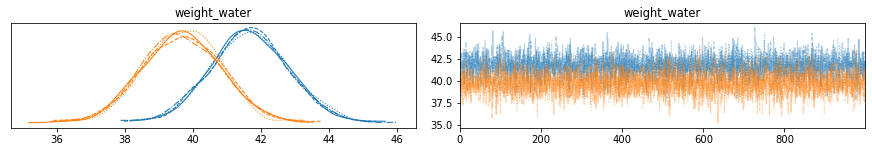

In [43]:
# blue line --> blue bucket
# orange line --> yellow bucket
az.plot_trace(idata_prec.posterior.weight_water, compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000225FCBABE80>,
      dtype=object)

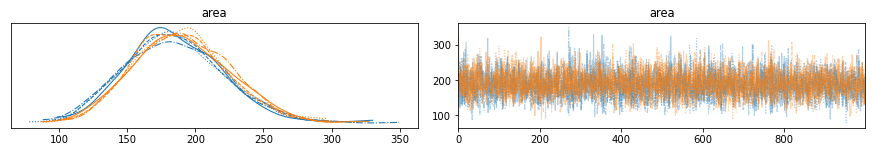

In [44]:
az.plot_trace(idata_prec.posterior.area, compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000225FD268B70>,
      dtype=object)

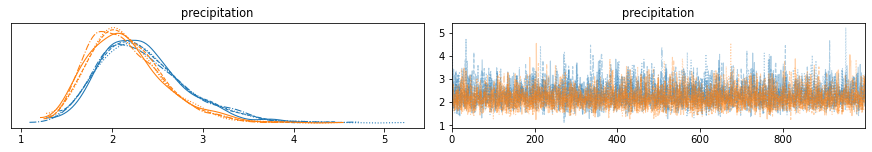

In [45]:
az.plot_trace(idata_prec.posterior.precipitation, compact=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000225FD3346A0>,
      dtype=object)

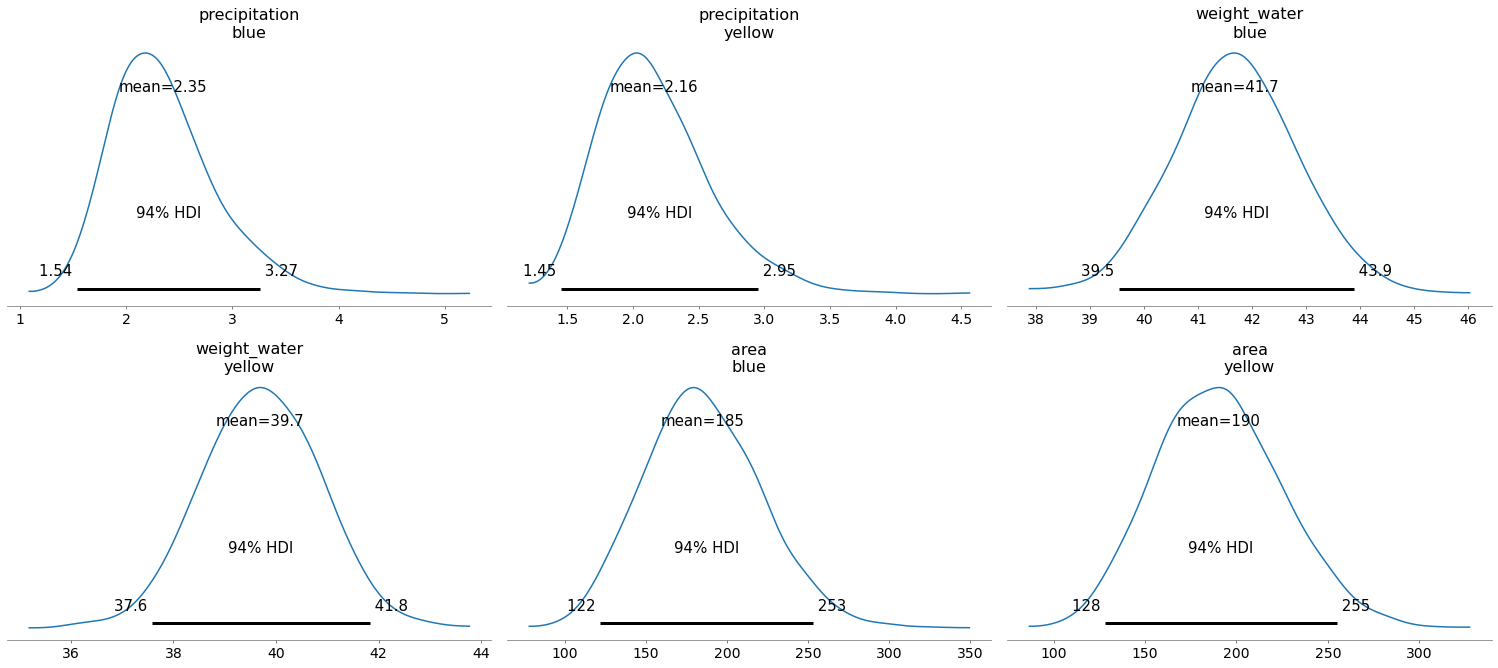

In [46]:
az.plot_posterior(idata_prec, var_names=["precipitation", "weight_water", "area"], round_to=3)

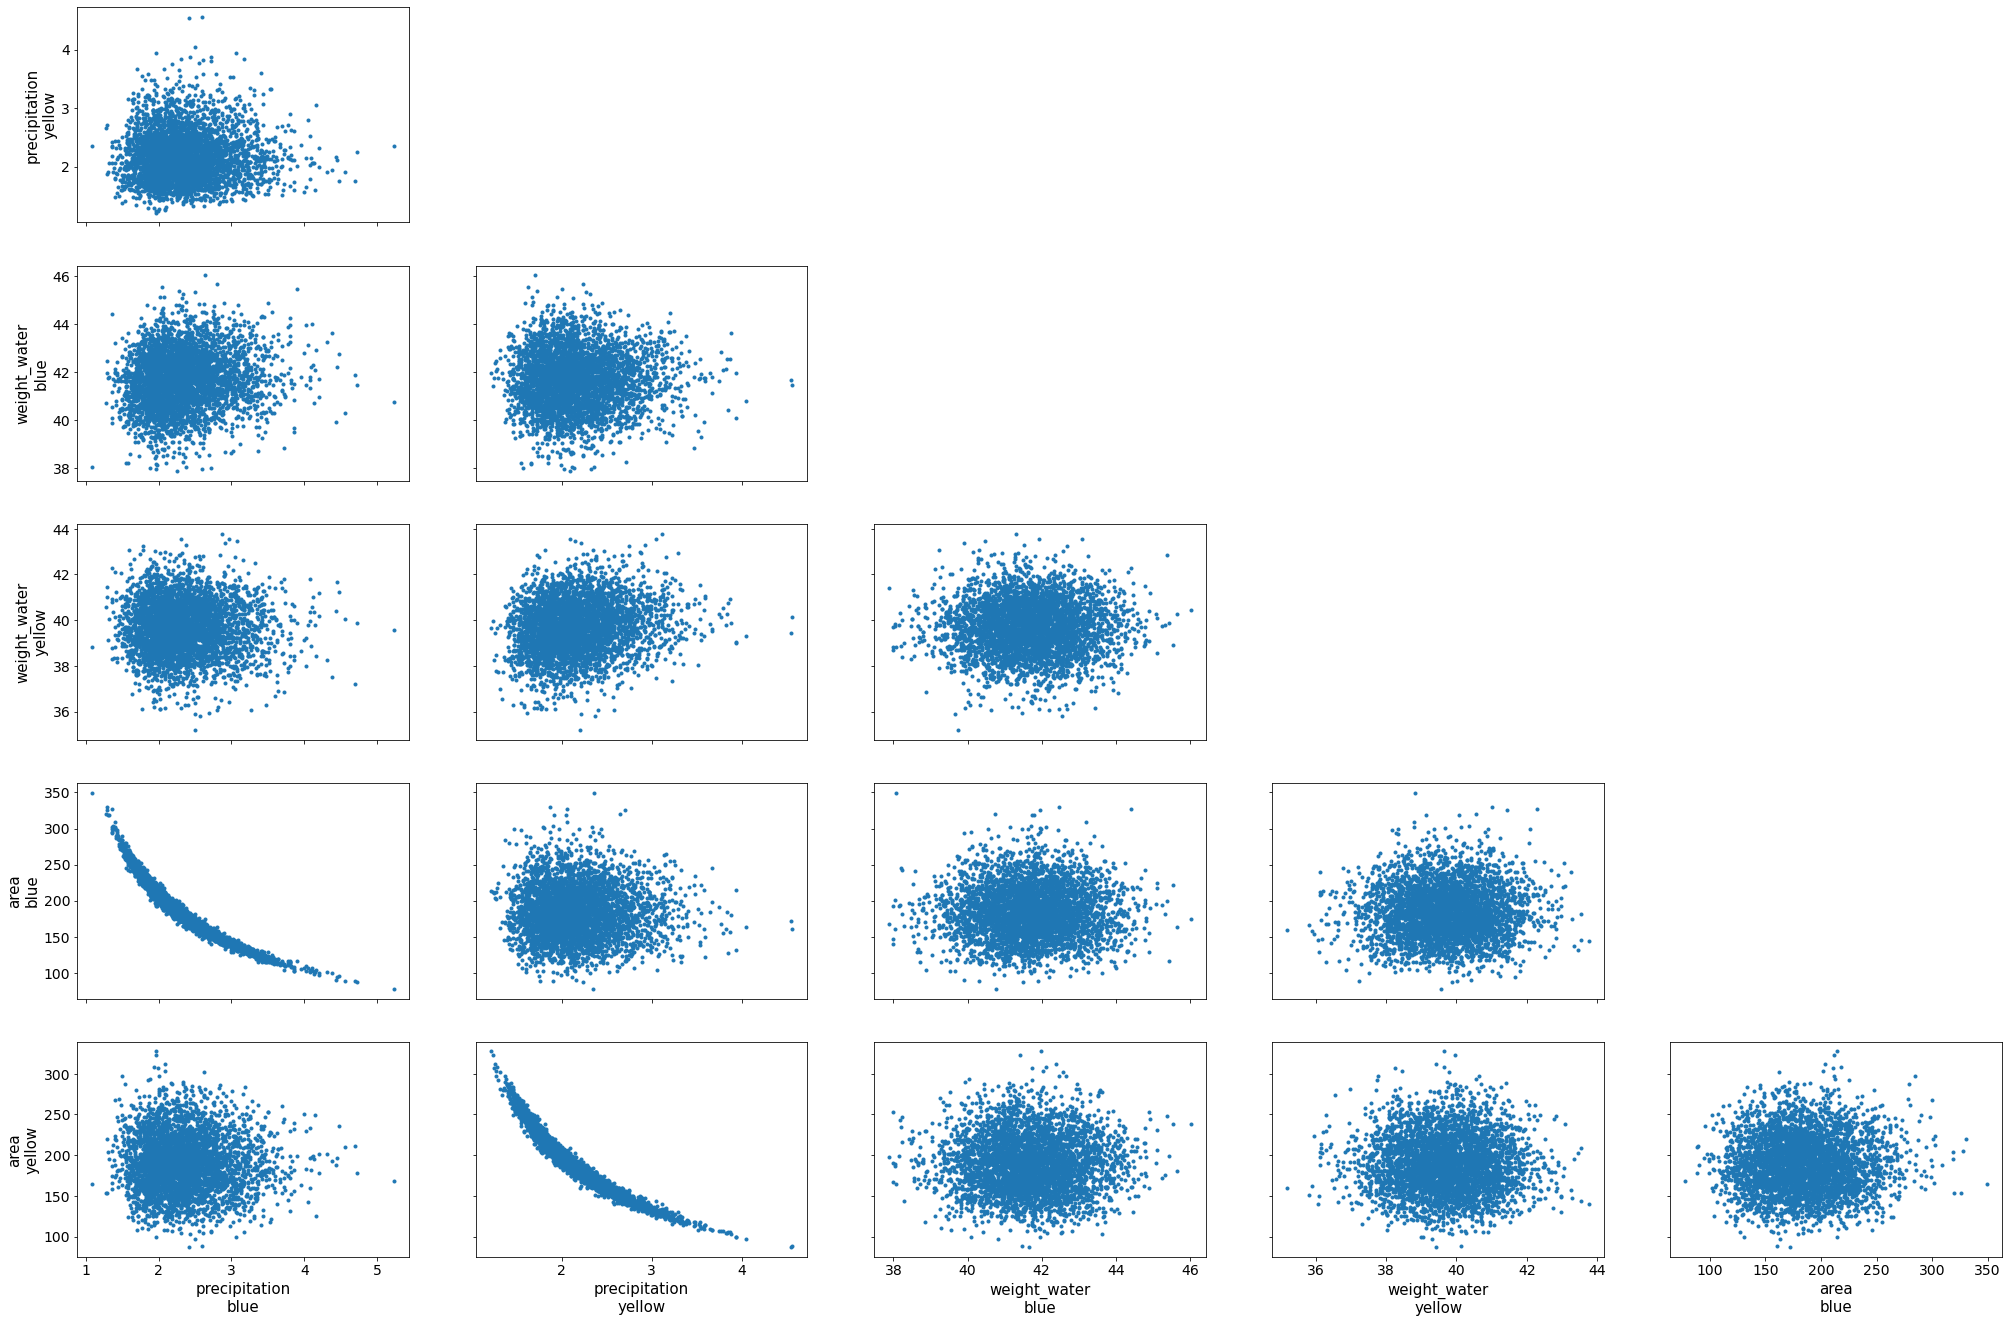

In [47]:
az.plot_pair(idata_prec, var_names=["precipitation", "weight_water", "area"], divergences=True);

## Combine precipitation measurements
This basically means that we weight each bucket equally --> 0.5, 0.5

In [48]:
precipitation_stan = idata_prec.posterior.precipitation.values.ravel()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000225FE637D68>],
      dtype=object)

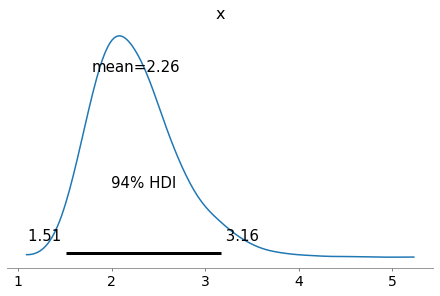

In [49]:
az.plot_posterior(precipitation_stan, round_to=3)

In [50]:
az.summary(precipitation_stan, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,2.255,0.461,1.514,3.165
